In [1]:
import numpy as np
import decimal
import matplotlib.pyplot as plt
from scipy import interpolate as intp
from scipy import stats
import seaborn as sns
from itertools import compress
from matplotlib.pyplot import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage.filters import gaussian_filter
from scipy.optimize import *
from scipy import signal
from scipy import stats
from scipy.signal import convolve as sig_convolve
from scipy.io import loadmat
from scipy.io import savemat
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm

import cv2
import time

import datajoint as dj

dj.config['database.host'] = 'at-database.ad.bcm.edu'
dj.config['database.user'] = 'raj'
dj.config['database.password'] = 'language-wonderful-joy-system'
dj.conn()

Connecting raj@at-database.ad.bcm.edu:3306


DataJoint connection (connected) raj@at-database.ad.bcm.edu:3306

In [2]:
from stimulus import stimulus
import datajoint as dj
tune=dj.create_virtual_module('tune','pipeline_tune')
GNN=dj.create_virtual_module('GNN', 'pipeline_GNN')
meso=dj.create_virtual_module('meso','pipeline_meso')

In [3]:
from neuro_data.movies import data_schemas
from neuro_data.movies.stats import load_dataset

/Users/rajdbz/anaconda/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
def Extract_Orientation_Contrast(frame, ksize, sigma_o, sigma_c, rs):
    """
    Function that estimates the local orientation and contrast at each pixel in the input image frame.
    Inputs:
    frame   - input image
    ksize   - kernel size of the gaussian kernel used to smooth the squared gradients
    sigma_o - standard deviation of the gaussian kernel for estimating orientations
    sigma_c - standard deviation of the gaussian kernel for estimating orientations
    rs      - factor by which to resize the gradient functions
    
    Outputs: 
    Ohat  - estimated orientation
    Chat  - estimated contrast
    """

    # First, compute the gradients
    gx = frame[:,1:] - frame[:,0:-1]
    gx = np.concatenate((gx,np.expand_dims(gx[:,-1],axis=1)),axis=1)

    gy = frame[1:,:] - frame[0:-1,:]
    gy = np.concatenate((gy,np.expand_dims(gy[-1,:],axis=0)),axis=0)

    gxx = gx**2
    gyy = gy**2
    gxy = gx*gy

    # smoothen these sqaured gradients if needed
    gxx = cv2.GaussianBlur(gxx,(ksize,ksize),sigma_o)
    gyy = cv2.GaussianBlur(gyy,(ksize,ksize),sigma_o)
    gxy = cv2.GaussianBlur(gxy,(ksize,ksize),sigma_o)

    # resize these gradient functions
    if rs != 1:
        gxx = cv2.resize(gxx,None,fx=rs, fy=rs, interpolation = cv2.INTER_LANCZOS4)
        gyy = cv2.resize(gyy,None,fx=rs, fy=rs, interpolation = cv2.INTER_LANCZOS4)
        gxy = cv2.resize(gxy,None,fx=rs, fy=rs, interpolation = cv2.INTER_LANCZOS4)

    # Compute local orientations
    Ohat = np.zeros(gxx.shape)
    
    M = np.zeros([gxx.shape[0], gxx.shape[1], 2,2])
    M[:,:,0,0] = gxx
    M[:,:,1,1] = gyy
    M[:,:,0,1] = gxy
    M[:,:,1,0] = gxy
    D, V = np.linalg.eig(M)

    ind0 = (np.sign(D[:,:,0] - D[:,:,1])+1)/2
    ind1 = (np.sign(D[:,:,1] - D[:,:,0])+1)/2

    Ohat = np.arctan2(V[:,:,1,0]*ind0 + V[:,:,1,1]*ind1,V[:,:,0,0]*ind0 + V[:,:,0,1]*ind1)
    
    # Align the orientation such that 0 radians is north, pi/2 is west and pi is south
    Ohat = np.mod(-Ohat,np.pi)

    Chat = np.sqrt(gx**2 + gy**2)
    Chat = cv2.GaussianBlur(Chat,(ksize,ksize),sigma_c)
    if rs != 1:
        Chat = cv2.resize(Chat,None,fx=rs, fy=rs, interpolation = cv2.INTER_LANCZOS4)
    
    return Ohat, Chat

In [5]:
# define custom functions
def pick_indices(x,l,u):
    """
    Pick the elements of an array x that lie between l and u
    """
    id_s = np.nonzero(x >= l)[0]
    id_e = np.nonzero(x <= u)[0]
    return np.intersect1d(id_s,id_e)

def vonMisesFn(x,amp,scale,theta0):
    """
    Von Mises function, but for orientations
    x goes from (0, pi)
    """
    return amp*np.exp(scale*np.cos(2*(x-theta0)))

def expandN_dims(x,N):
    """
    Add N extra dimensions to x
    """
    dims = np.shape(x.shape)[0] 
    for i in range(N):
        x = np.expand_dims(x,axis=dims+i)
    return x

def sigmoid(x):
    return 1/(1 + np.exp(-x))

In [6]:
# load the dataset
key = (data_schemas.MovieMultiDataset.Member & 'group_id=9').fetch('KEY')
#key = (data_schemas.MovieMultiDataset.Member & 'group_id=1').fetch('KEY')
dset = load_dataset(key)

In [7]:
key

[{'animal_id': 16314,
  'group_id': 9,
  'pipe_version': 1,
  'preproc_id': 0,
  'scan_idx': 1,
  'segmentation_method': 3,
  'session': 3,
  'spike_method': 5}]

In [8]:
Ns = len(dset) #no. of stimulus clips
T, Ny, Nx = dset[0].inputs.shape[1:]

OhatFull = np.zeros([Ns, T, Ny, Nx])
ChatFull = np.zeros([Ns, T, Ny, Nx])

# parameters for the image processing
ksize = 19
sigma_o = 5
sigma_c = 5
rs = 1.0

In [11]:
TVec = np.zeros([len(dset)])
for k in range(len(dset)):
    TVec[k] = dset[k].inputs.shape[1]

In [13]:
# Compute the local orientation and contrast at each spatial location for all the clips
t_st = time.time()  
for s in range(5):
    if np.mod(s,50) == 0:
        print(s)
    for t in range(T):
        image = dset[s].inputs[0,t,:,:]
        OhatFull[s,t,:,:], ChatFull[s,t,:,:] = Extract_Orientation_Contrast(np.double(image), ksize, sigma_o, sigma_c, rs)

t_en = time.time()
print('time elapsed =', t_en-t_st)


0
time elapsed = 23.330769062042236


In [14]:
# quantize Chat and Ohat
OhatFull = np.uint8(np.floor(256*OhatFull/np.pi))
ChatFull = np.uint8(np.floor(256*ChatFull/np.max(ChatFull)))

In [11]:
# save the estimated contrast and orientation data
mdict = {'OhatFull':OhatFull,'ChatFull':ChatFull}
fname = './Estimated_features_Dataset9.mat'
savemat(fname, mdict)

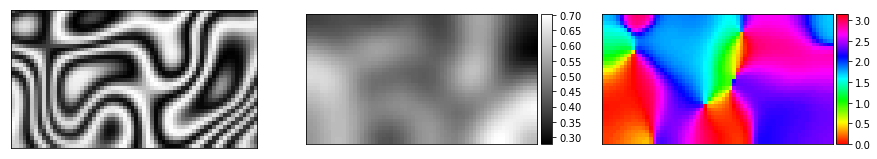

In [17]:
# Plot example image, estimated orientation and orientation maps
s = 10
t = 250
image = dset[s].inputs[0,t,:,:]
Ohat = OhatFull[s,t,:,:]
Chat = ChatFull[s,t,:,:]

fig, axes = plt.subplots(1,3,figsize=[15,4])

axes[0].imshow(image,cmap='gray')
axes[0].set_xticks([]); axes[0].set_yticks([])


im = axes[1].imshow(Chat/256.0,cmap='gray')
axes[1].set_xticks([]); axes[1].set_yticks([])
divider = make_axes_locatable(axes[1])

cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axes[2].imshow(Ohat*np.pi/256.0,cmap='hsv',vmin = 0, vmax = np.pi)
axes[2].set_xticks([]); axes[2].set_yticks([])
divider = make_axes_locatable(axes[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

plt.show()

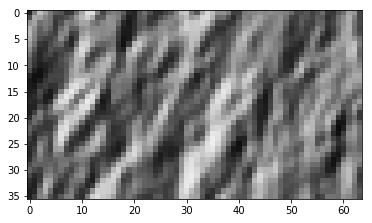

In [31]:
img = dset[0].inputs[0,0]
img = np.tanh((img - 127.5)*2/127.5)*127.5 + 127.5
plt.imshow(img,cmap='gray',vmin=0,vmax=255)

In [14]:
# Create the monet movies with different contrast

Nbins_c = 11
ImageSet = np.zeros([Nbins_c,T,Ny,Nx])
ImageSet[0] = dset[0].inputs[0]
for k in range(1,Nbins_c):
    ImageSet[k] = np.tanh((dset[0].inputs[0] - 127.5)*(0.5*(k-1) + 0.2)/127.5)*127.5 + 127.5



In [15]:
# compute the local orientations and contrasts of these images
OMapSet = np.zeros([Nbins_c,T,Ny,Nx])
CMapSet = np.zeros([Nbins_c,T,Ny,Nx])

for k in range(Nbins_c):
    for t in range(T):
        image = ImageSet[k,t,:,:]
        OMapSet[k,t,:,:], CMapSet[k,t,:,:] = Extract_Orientation_Contrast(np.double(image), ksize, sigma_o, sigma_c, 1.0)
        
# quantize Chat and Ohat
OMapSet = np.uint8(np.floor(256*OMapSet/np.pi))
CMapSet = np.uint8(np.floor(256*CMapSet/np.max(CMapSet)))

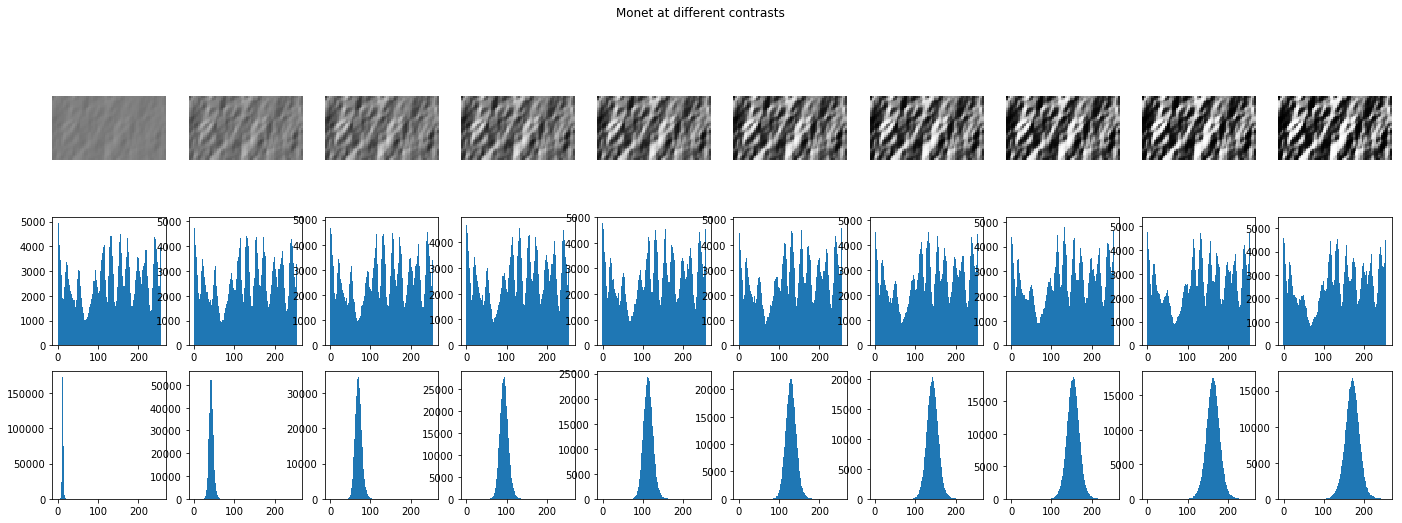

In [16]:
fig, ax = plt.subplots(3,Nbins_c-1,figsize=(24,8))
plt.suptitle('Monet at different contrasts')
for k in range(Nbins_c-1):
    ax[0,k].imshow(ImageSet[k+1,0],vmin=0,vmax=255,cmap='gray')
    ax[0,k].axis('off')
    ax[1,k].hist(OMapSet[k+1].flatten(),bins=np.arange(257)-0.5)
    ax[2,k].hist(CMapSet[k+1].flatten(),bins=np.arange(257)-0.5)
    

#     plt.imshow(dset[np.random.randint(Ns)].inputs[0,0],vmin =0,vmax=255,cmap='gray')
#     plt.axis('off')
plt.show()

In [18]:
MeanC = np.zeros([Nbins_c])
for k in range(1,Nbins_c):
    MeanC[k]=CMapSet[k].mean()


In [13]:
36*64*143*300*10/1024/1024

942.626953125

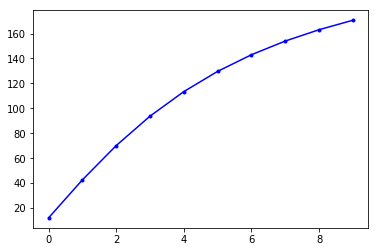

In [19]:
plt.plot(MeanC[1:],'b.-')